# CIC IDS 2017

# 1. Import libraries

In [2]:
import os
import gc
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from prettytable import PrettyTable
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.callback import EarlyStopping

In [2]:
for dirname, _, filenames in os.walk('data/CIC_IDS_2017/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/CIC_IDS_2017/README.md
data/CIC_IDS_2017/MachineLearningCSV.zip
data/CIC_IDS_2017/GeneratedLabelledFlows.md5
data/CIC_IDS_2017/GeneratedLabelledFlows.zip
data/CIC_IDS_2017/download_dataset
data/CIC_IDS_2017/MachineLearningCSV.md5
data/CIC_IDS_2017/TrafficLabelling /Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling /Monday-WorkingHours.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling /Friday-WorkingHours-Morning.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling /Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling /Tuesday-WorkingHours.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling /Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling /Wednesday-workingHours.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling /Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
data/CIC_IDS_2017/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
data/CIC_IDS_20

# 2. Load data

In [4]:
monday = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv', sep=",", encoding='utf-8')
tuesday = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv', sep=",", encoding='utf-8')
wednesday = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv', sep=",", encoding='utf-8')
thursday_morning = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', sep=",", encoding='utf-8')
thursday_afternoon = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', sep=",", encoding='utf-8')
friday_ddos = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', sep=",", encoding='utf-8')
friday_pcap = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', sep=",", encoding='utf-8')
friday_morning = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv', sep=",", encoding='utf-8')
monday.name = 'Monday'
tuesday.name = 'Tuesday'
wednesday.name = 'Wednesday'
thursday_morning.name = 'Thursday_Morning'
thursday_afternoon.name = 'Thursday_Afternoon'
friday_ddos.name = 'Friday_DDoS'
friday_pcap.name = 'Friday_Pcap'
friday_morning.name = 'Friday_Morning'

In [20]:
def missing_values(df):
    """
    Print a table with missing values
    """
    table = PrettyTable(["Column", "All Values", "Missing Values", "% of missing values"])
    NaN_columns = []
    columns = df.columns
    for column in columns:
        all_values = df[column].count()
        missing_values = df[column].isna().sum()
        if missing_values > 0:
            NaN_columns.append(column)
        percentage = f'{(missing_values / all_values)*100:.2f}'
        table.add_row([column, all_values, missing_values, f'{percentage}%'])
    data = table.get_string()
    with open(f"Missing_table.txt", 'w') as f:
        f.write(data)
    print(table)
    if len(NaN_columns) > 0:
        print(f"Columns with missing values: {NaN_columns}")
    print(f"Table saved as Missing_table.txt")

In [5]:
dataframes = [monday, tuesday, wednesday, thursday_morning, thursday_afternoon, friday_ddos, friday_morning, friday_pcap]
data = pd.concat(dataframes)

In [6]:
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2830743 entries, 0 to 286466
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max               

In [8]:
data.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [9]:
data[' Label'].unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'Infiltration', 'DDoS', 'Bot',
       'PortScan'], dtype=object)

In [10]:
data[' Label'].value_counts()

 Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [11]:
data = data.replace([-np.inf, np.inf], np.nan)

In [21]:
missing_values(data)

+------------------------------+------------+----------------+---------------------+
|            Column            | All Values | Missing Values | % of missing values |
+------------------------------+------------+----------------+---------------------+
|       Destination Port       |  2830743   |       0        |        0.00%        |
|         Flow Duration        |  2830743   |       0        |        0.00%        |
|       Total Fwd Packets      |  2830743   |       0        |        0.00%        |
|    Total Backward Packets    |  2830743   |       0        |        0.00%        |
| Total Length of Fwd Packets  |  2830743   |       0        |        0.00%        |
|  Total Length of Bwd Packets |  2830743   |       0        |        0.00%        |
|     Fwd Packet Length Max    |  2830743   |       0        |        0.00%        |
|     Fwd Packet Length Min    |  2830743   |       0        |        0.00%        |
|    Fwd Packet Length Mean    |  2830743   |       0        |   

In [22]:
data[data.isna().any(axis=1)==True]

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
33,1029,0,2,0,12,0,6,6,6.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
77,49478,0,2,0,37,0,31,6,18.5,17.677670,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
80,49478,0,2,0,37,0,31,6,18.5,17.677670,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
92,49488,0,2,0,12,0,6,6,6.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
97,49488,0,2,0,12,0,6,6,6.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278979,51396,0,2,0,12,0,6,6,6.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
279129,49884,0,2,0,14,0,14,0,7.0,9.899495,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
281744,443,0,2,0,12,0,6,6,6.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
282054,443,0,2,0,12,0,6,6,6.0,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [23]:
data.dropna(inplace=True)

In [24]:
missing_values(data)

+------------------------------+------------+----------------+---------------------+
|            Column            | All Values | Missing Values | % of missing values |
+------------------------------+------------+----------------+---------------------+
|       Destination Port       |  2827876   |       0        |        0.00%        |
|         Flow Duration        |  2827876   |       0        |        0.00%        |
|       Total Fwd Packets      |  2827876   |       0        |        0.00%        |
|    Total Backward Packets    |  2827876   |       0        |        0.00%        |
| Total Length of Fwd Packets  |  2827876   |       0        |        0.00%        |
|  Total Length of Bwd Packets |  2827876   |       0        |        0.00%        |
|     Fwd Packet Length Max    |  2827876   |       0        |        0.00%        |
|     Fwd Packet Length Min    |  2827876   |       0        |        0.00%        |
|    Fwd Packet Length Mean    |  2827876   |       0        |   

# 3. Exploratory Data Analysis

In [25]:
label = data[' Label'].value_counts().index.tolist()
count = data[' Label'].value_counts()

In [26]:
label

['BENIGN',
 'DoS Hulk',
 'PortScan',
 'DDoS',
 'DoS GoldenEye',
 'FTP-Patator',
 'SSH-Patator',
 'DoS slowloris',
 'DoS Slowhttptest',
 'Bot',
 'Web Attack � Brute Force',
 'Web Attack � XSS',
 'Infiltration',
 'Web Attack � Sql Injection',
 'Heartbleed']

In [27]:
count

 Label
BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

## 3.1 Histogram

In [30]:
def hist_plot(label, count):
    _dict = {}
    for x in range(len(label)):
        _dict[label[x]] = count.iloc[x]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(_dict.keys(), _dict.values())
    ax.set_title('Traffic type distribution', fontsize=16, fontweight="bold")
    ax.set_xlabel('Traffic type')
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_ylabel('Distribution')
    ax.grid(which='Major', axis='both')
    plt.savefig("Traffic_type_distribution.png")

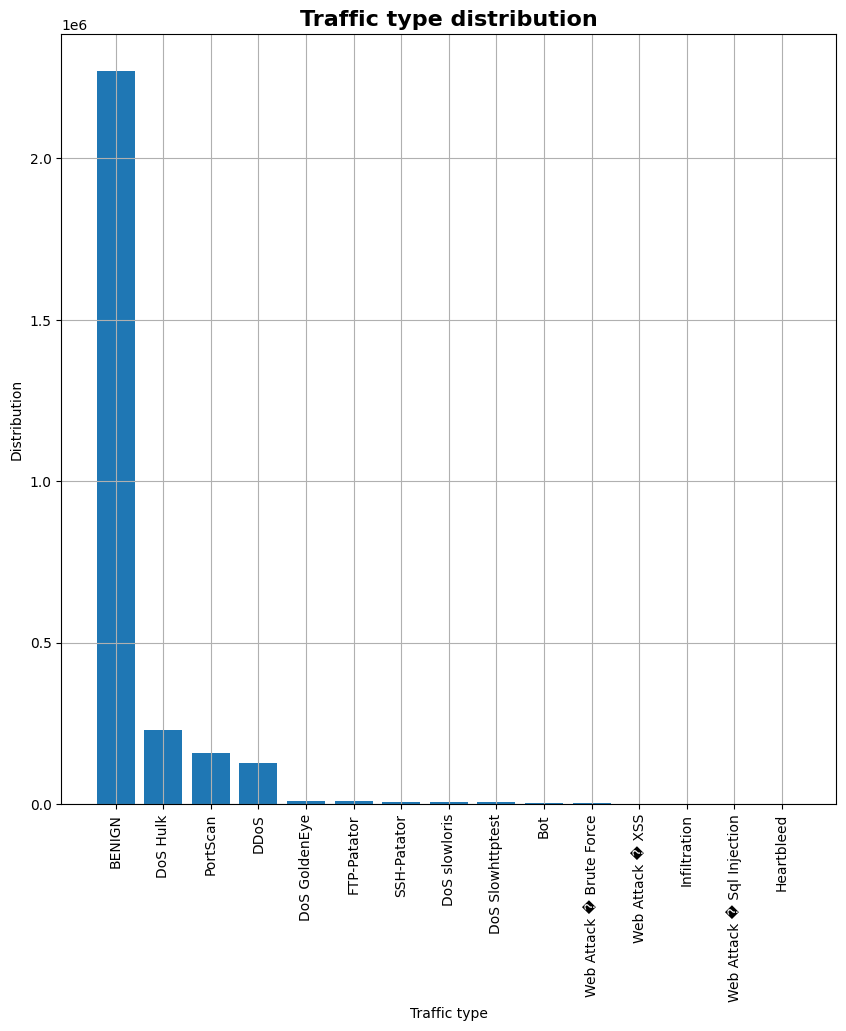

In [31]:
hist_plot(label, count)

In [32]:
def attack_plot(label, count):
    _dict = {}
    label = [x for x in label if x != 'BENIGN']
    count = count.iloc[1:len(count)]
    for x in range(len(label)):
        _dict[label[x]] = count.iloc[x]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(_dict.keys(), _dict.values())
    ax.set_title('Attack type distribution', fontsize=16, fontweight="bold")
    ax.set_xlabel('Traffic type')
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_ylabel('Distribution')
    ax.grid(which='Major', axis='both')
    plt.savefig("attack_type_distribution.png")

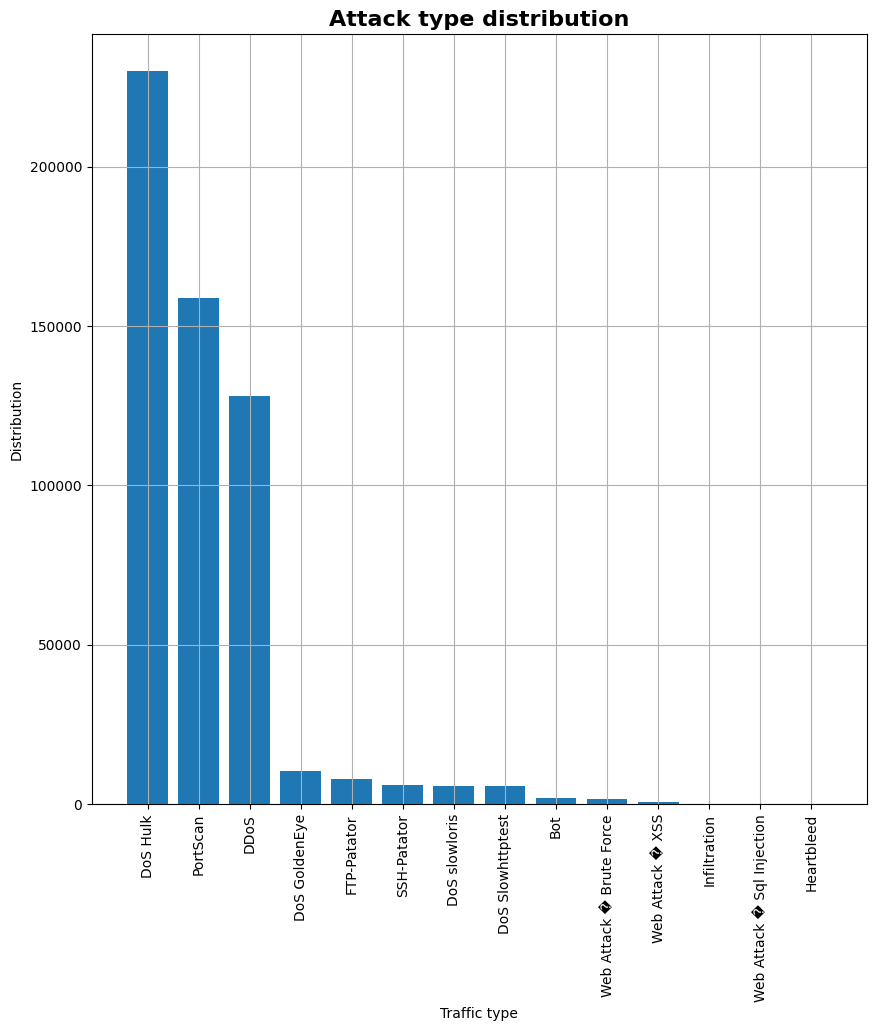

In [33]:
attack_plot(label, count)

## 3.2 Correlation matrix

In [34]:
X = data.drop([' Label'], axis=1)
y = data[' Label']

In [35]:
X.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0


In [39]:
y.unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'Infiltration', 'DDoS', 'Bot',
       'PortScan'], dtype=object)

In [40]:
len(y.unique())

15

## 3.4 Data Scaling

In [25]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [26]:
X

array([[7.50560769e-01, 1.41666654e-07, 4.55046005e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.50560769e-01, 1.16666656e-07, 4.55046005e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.50560769e-01, 1.16666656e-07, 4.55046005e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [6.75974670e-03, 1.34844154e-03, 3.13981744e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.75974670e-03, 1.19064156e-03, 2.22972543e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.75974670e-03, 1.55784152e-03, 2.04770702e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

## 3.5 Save Data

In [54]:
np.save('data/CIC_IDS_2017/prepared_train_data.npy', X)
np.save('data/CIC_IDS_2017/prepared_train_labels.npy', y)

## 3.6 Load Data

In [8]:
X = np.load('data/CIC_IDS_2017/prepared_train_data.npy')
y = np.load('data/CIC_IDS_2017/prepared_train_labels.npy')

In [9]:
X

array([[ 2.25050642, -0.43961241, -0.00982461, ..., -0.10461905,
        -0.14940357, -0.10951643],
       [ 2.25050642, -0.4396125 , -0.00982461, ..., -0.10461905,
        -0.14940357, -0.10951643],
       [ 2.25050642, -0.4396125 , -0.00982461, ..., -0.10461905,
        -0.14940357, -0.10951643],
       ...,
       [-0.41689841, -0.4348067 ,  0.08083571, ..., -0.10461905,
        -0.14940357, -0.10951643],
       [-0.41689841, -0.43536915,  0.05417091, ..., -0.10461905,
        -0.14940357, -0.10951643],
       [-0.41689841, -0.43406035,  0.04883795, ..., -0.10461905,
        -0.14940357, -0.10951643]])

In [10]:
y

array([0, 0, 0, ..., 0, 0, 0])

# 4. Create Models

## 4.1 Evaluation metrics

In [21]:
def accuracy(y_val, y_preds, count=0):
    for x in range(len(y_val)):
        if y_val[x] == y_preds[x]:
            count += 1
    return count / len(y_preds)

## 4.2 Split data

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [32]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)

In [33]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1971029, 32), (1971029,), (432665, 32), (432665,), (424182, 32), (424182,))

In [35]:
from tensorflow import keras

In [40]:
len(np.unique(y_train))

15

In [36]:
X_train.shape[1]

32

In [57]:
def create_model(X_train, y_train):
    model = keras.Sequential()
    model.add(keras.layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(len(np.unique(y_train)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # Compile the model
    return model

In [58]:
model = create_model(X_train, y_train)
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,359 (52.18 KB)

 Trainable params: 13,359 (52.18 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
model.fit(X_train, y_train,
          batch_size=32,
          epochs=20,
          validation_data=(X_val, y_val))

Epoch 1/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 102s 2ms/step - accuracy: 0.9674 - loss: 0.0826 - val_accuracy: 0.9810 - val_loss: 0.0457
Epoch 2/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 102s 2ms/step - accuracy: 0.9801 - loss: 0.0477 - val_accuracy: 0.9830 - val_loss: 0.0443
Epoch 3/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 103s 2ms/step - accuracy: 0.9817 - loss: 0.0436 - val_accuracy: 0.9813 - val_loss: 0.0437
Epoch 4/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 103s 2ms/step - accuracy: 0.9824 - loss: 0.0421 - val_accuracy: 0.9838 - val_loss: 0.0401
Epoch 5/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 103s 2ms/step - accuracy: 0.9827 - loss: 0.0410 - val_accuracy: 0.9799 - val_loss: 0.0643
Epoch 6/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 102s 2ms/step - accuracy: 0.9831 - loss: 0.0405 - val_accuracy: 0.9817 - val_loss: 0.0420
Epoch 7/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 87s 1ms/step - accuracy: 0.9831 - loss: 0.0402 - val_accuracy: 0.9833 - val_loss: 0.0401
Epoch 8/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 87s 1ms/step - accu

In [60]:
import gc

gc.collect()

6984

In [65]:
_, accuracy = model.evaluate(X_test, y_test)

13256/13256 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - accuracy: 0.9803 - loss: 0.0444


In [66]:
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 98.05%
